In [24]:
import pandas as pd
import sqlite3
import random
import requests

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from PIL import Image
from io import BytesIO

In [78]:
conn = sqlite3.connect('nfl_data.sqlite')

In [79]:
teams_df = pd.read_sql('SELECT * FROM teams', conn).set_index('abbreviation')

In [80]:
games_df = pd.read_sql('SELECT * FROM games', conn).set_index('gameId')

In [81]:
plays_df = pd.read_sql('SELECT * FROM plays', conn).set_index('play_uuid')

In [82]:
# (GITHUB COLAB AI) 
# prompt: load all CSV files with a name like "tracking_week_" into a tracking_df dataframe
import glob
tracking_df = pd.concat(map(pd.read_csv, glob.glob(f'data/nfl-big-data-bowl-2024/*week*.csv')))
# generate same Play-UUID for frame lookup
tracking_df['play_uuid'] = tracking_df['gameId'].astype(str) + '.' + tracking_df['playId'].astype(str)
tracking_df['club'] = tracking_df['club'].replace('LA', 'LAR').replace('WAS', 'WSH')

In [83]:
# tracking_df = pd.read_sql('SELECT * FROM tracking', conn)

In [84]:
snap_formations_df = pd.read_sql('SELECT * FROM snap_formations', conn).set_index('play_uuid')
snap_formations_df.head()

,x0,y0,s0,a0,dis0,o0,dir0,x1,y1,s1,...,yardsToGo,preSnapHomeScore,preSnapVisitorScore,offenseFormation,defendersInTheBox,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,down
play_uuid,,,,,,,,,,,,,,,,,,,,,
2022090800.101,73.13,27.67,0.10,1.14,0.02,273.97,348.75,67.35,29.96,0.07,...,10,0,0,I_FORM,6.0,0.399819,0.600181,-0.014850,0.014850,1
2022090800.1187,71.72,29.54,0.05,0.85,0.01,272.46,55.53,69.25,24.99,0.14,...,10,0,10,SINGLEBACK,6.0,0.207237,0.792763,0.006345,-0.006345,1
2022090800.1254,59.81,23.63,0.00,0.00,0.00,272.98,143.12,42.18,36.75,0.65,...,10,0,10,PISTOL,6.0,0.227212,0.772788,0.008701,-0.008701,1
2022090800.1385,36.64,29.50,0.08,0.88,0.01,273.91,130.33,34.44,33.93,0.49,...,10,0,10,SINGLEBACK,6.0,0.235201,0.764799,0.027923,-0.027923,1
2022090800.1406,18.65,23.35,0.25,1.67,0.02,278.66,52.44,16.13,28.06,0.40,...,7,0,10,SINGLEBACK,6.0,0.263124,0.736876,0.000100,-0.000100,1


In [85]:
# Filter tracking_df for the Ball Snap Frames
ball_snap_df = tracking_df.loc[(tracking_df['event'] == 'ball_snap')] #| (tracking_df['event'] == 'autoevent_ballsnap')]
ball_snap_df.head()

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,play_uuid
5,2022100600,90,33084.0,Matt Ryan,6,2022-10-06 20:17:05.299999,2.0,IND,left,90.26,23.69,0.20,0.14,0.04,274.45,250.64,ball_snap,2022100600.90
65,2022100600,90,35459.0,Kareem Jackson,6,2022-10-06 20:17:05.299999,22.0,DEN,left,72.17,16.80,0.48,0.94,0.05,119.60,125.33,ball_snap,2022100600.90
125,2022100600,90,42030.0,K'Waun Williams,6,2022-10-06 20:17:05.299999,21.0,DEN,left,80.22,31.04,3.41,2.96,0.35,128.25,199.16,ball_snap,2022100600.90
185,2022100600,90,42393.0,Ronald Darby,6,2022-10-06 20:17:05.299999,23.0,DEN,left,76.83,36.25,0.04,0.14,0.01,73.29,206.98,ball_snap,2022100600.90
245,2022100600,90,43307.0,Ryan Kelly,6,2022-10-06 20:17:05.299999,78.0,IND,left,85.75,23.80,0.08,0.38,0.01,252.44,311.45,ball_snap,2022100600.90


In [86]:
position_counts = ball_snap_df[['play_uuid', 'nflId']].groupby('play_uuid').count()
snap_ids = position_counts.loc[(position_counts['nflId'] == 22)].index
snap_ids

Index(['2022090800.101', '2022090800.1187', '2022090800.1254',
       '2022090800.1385', '2022090800.1406', '2022090800.146',
       '2022090800.1736', '2022090800.191', '2022090800.1946',
       '2022090800.2043',
       ...
       '2022110700.3787', '2022110700.403', '2022110700.443', '2022110700.493',
       '2022110700.546', '2022110700.612', '2022110700.670', '2022110700.80',
       '2022110700.929', '2022110700.950'],
      dtype='object', name='play_uuid', length=6323)

In [87]:
snap_ids = [snap_id for snap_id in snap_ids if snap_id in plays_df.index]

In [223]:
scoring_plays = tracking_df.loc[(tracking_df['event'] == 'touchdown')]['play_uuid'].unique()

In [254]:
# Create a DF of the plays with all-22 Frames available
all_22_plays_df = plays_df.loc[snap_ids]
all_22_plays_df = all_22_plays_df.loc[all_22_plays_df['possessionTeam'] == 'IND']
all_22_plays_df

,gameId,playId,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,...,week,cumulativeOverall_O,cumulativeOverall_D,cumulativeOverall_P,cumulativePerFormation_O,cumulativePerFormation_D,cumulativePerFormation_P,cumulativePerBoxCt_O,cumulativePerBoxCt_D,cumulativePerBoxCt_P
play_uuid,,,,,,,,,,,,,,,,,,,,,
2022091105.101,2022091105,101,52449,Jonathan Taylor,(13:51) (Shotgun) J.Taylor up the middle to IN...,1,3,3,IND,HOU,...,1,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
2022091105.1194,2022091105,1194,52449,Jonathan Taylor,(7:17) J.Taylor right tackle to HST 45 for 2 y...,2,1,10,IND,HOU,...,1,0.400000,0.600000,0.181818,0.444444,0.555556,0.200000,0.333333,0.666667,0.250000
2022091105.1215,2022091105,1215,52449,Jonathan Taylor,(6:39) J.Taylor right guard to HST 38 for 7 ya...,2,2,8,IND,HOU,...,1,0.380952,0.619048,0.166667,0.400000,0.600000,0.166667,0.307692,0.692308,0.222222
2022091105.1236,2022091105,1236,52449,Jonathan Taylor,(5:55) B.Raimann reported in as eligible. J.T...,2,3,1,IND,HOU,...,1,0.363636,0.636364,0.153846,0.000000,0.000000,0.000000,0.428571,0.571429,0.000000
2022091105.1480,2022091105,1480,46173,Nyheim Hines,"(2:15) (No Huddle, Shotgun) N.Hines left guard...",2,2,5,IND,HOU,...,1,0.360000,0.640000,0.200000,0.300000,0.700000,0.333333,0.266667,0.733333,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022110605.419,2022110605,419,53647,Sam Ehlinger,(9:02) (Shotgun) S.Ehlinger left guard to NE 4...,1,2,10,IND,NE,...,9,0.363409,0.623188,0.250000,0.382456,0.601036,0.200000,0.346491,0.515625,0.200000
2022110605.634,2022110605,634,53703,Deon Jackson,(3:21) D.Jackson right guard to IND 27 for 3 y...,1,1,10,IND,NE,...,9,0.362500,0.624277,0.279070,0.325581,0.652632,0.250000,0.208333,0.729167,0.500000
2022110605.655,2022110605,655,53703,Deon Jackson,(2:47) (Shotgun) D.Jackson up the middle to IN...,1,2,7,IND,NE,...,9,0.361596,0.625360,0.272727,0.381119,0.603093,0.310345,0.344978,0.519380,0.260870


In [255]:
# filter for tracking frames from the all-22 df and the ball snap event.
# These will all be 22 players and the ball for each play_uuid
all_22_frames_df = ball_snap_df.loc[(ball_snap_df['play_uuid'].isin(snap_ids))]
all_22_frames_df.head()

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,play_uuid
5,2022100600,90,33084.0,Matt Ryan,6,2022-10-06 20:17:05.299999,2.0,IND,left,90.26,23.69,0.20,0.14,0.04,274.45,250.64,ball_snap,2022100600.90
65,2022100600,90,35459.0,Kareem Jackson,6,2022-10-06 20:17:05.299999,22.0,DEN,left,72.17,16.80,0.48,0.94,0.05,119.60,125.33,ball_snap,2022100600.90
125,2022100600,90,42030.0,K'Waun Williams,6,2022-10-06 20:17:05.299999,21.0,DEN,left,80.22,31.04,3.41,2.96,0.35,128.25,199.16,ball_snap,2022100600.90
185,2022100600,90,42393.0,Ronald Darby,6,2022-10-06 20:17:05.299999,23.0,DEN,left,76.83,36.25,0.04,0.14,0.01,73.29,206.98,ball_snap,2022100600.90
245,2022100600,90,43307.0,Ryan Kelly,6,2022-10-06 20:17:05.299999,78.0,IND,left,85.75,23.80,0.08,0.38,0.01,252.44,311.45,ball_snap,2022100600.90


In [256]:
# Select a random play from the all-22 plays
random_play =  random.randint(0, len(all_22_plays_df))
# Select the play record
play = all_22_plays_df.iloc[random_play]
random_id = play.name
play

gameId                                                                     2022091105
playId                                                                            101
ballCarrierId                                                                   52449
ballCarrierDisplayName                                                Jonathan Taylor
playDescription                     (13:51) (Shotgun) J.Taylor up the middle to IN...
quarter                                                                             1
down                                                                                3
yardsToGo                                                                           3
possessionTeam                                                                    IND
defensiveTeam                                                                     HOU
yardlineSide                                                                      IND
yardlineNumber                                        

In [257]:
play_frames = tracking_df.loc[((tracking_df['gameId'] == play['gameId']) & (tracking_df['playId'] == play['playId']))]
play_frames

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,play_uuid
564903,2022091105,101,33084.0,Matt Ryan,1,2022-09-11 13:06:01.299999,2.0,IND,left,82.460000,29.720000,0.11,1.19,0.01,270.74,187.28,NaN,2022091105.101
564904,2022091105,101,33084.0,Matt Ryan,2,2022-09-11 13:06:01.400000,2.0,IND,left,82.460000,29.720000,0.14,1.09,0.01,273.76,247.49,NaN,2022091105.101
564905,2022091105,101,33084.0,Matt Ryan,3,2022-09-11 13:06:01.500000,2.0,IND,left,82.440000,29.720000,0.20,0.92,0.02,275.97,268.13,NaN,2022091105.101
564906,2022091105,101,33084.0,Matt Ryan,4,2022-09-11 13:06:01.599999,2.0,IND,left,82.420000,29.720000,0.26,0.70,0.02,277.13,274.53,NaN,2022091105.101
564907,2022091105,101,33084.0,Matt Ryan,5,2022-09-11 13:06:01.700000,2.0,IND,left,82.390000,29.720000,0.28,0.33,0.03,276.01,263.82,NaN,2022091105.101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566692,2022091105,101,NaN,football,74,2022-09-11 13:06:08.599999,NaN,football,left,77.379997,36.959999,1.61,2.26,0.17,NaN,NaN,tackle,2022091105.101
566693,2022091105,101,NaN,football,75,2022-09-11 13:06:08.700000,NaN,football,left,77.440002,37.090000,1.36,2.63,0.15,NaN,NaN,NaN,2022091105.101
566694,2022091105,101,NaN,football,76,2022-09-11 13:06:08.799999,NaN,football,left,77.510002,37.200001,1.11,2.53,0.13,NaN,NaN,NaN,2022091105.101
566695,2022091105,101,NaN,football,77,2022-09-11 13:06:08.900000,NaN,football,left,77.550003,37.330002,0.90,2.28,0.13,NaN,NaN,NaN,2022091105.101


In [258]:
len(tracking_df['nflId'].unique())

1684

In [259]:
# Select the tracking player positions from ball-snap for this play
play_frame = ball_snap_df.loc[(ball_snap_df['play_uuid'] == play.name)]
play_frame

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,play_uuid
564908,2022091105,101,33084.0,Matt Ryan,6,2022-09-11 13:06:01.799999,2.0,IND,left,82.36,29.72,0.32,0.28,0.03,276.01,277.73,ball_snap,2022091105.101
564986,2022091105,101,35470.0,Jerry Hughes,6,2022-09-11 13:06:01.799999,55.0,HOU,left,76.92,34.55,0.40,0.20,0.04,103.57,93.31,ball_snap,2022091105.101
565064,2022091105,101,41300.0,Christian Kirksey,6,2022-09-11 13:06:01.799999,58.0,HOU,left,75.58,28.54,0.64,0.27,0.06,105.07,196.44,ball_snap,2022091105.101
565142,2022091105,101,42441.0,Steven Nelson,6,2022-09-11 13:06:01.799999,21.0,HOU,left,76.51,41.19,0.00,0.00,0.00,58.74,83.42,ball_snap,2022091105.101
565220,2022091105,101,43307.0,Ryan Kelly,6,2022-09-11 13:06:01.799999,78.0,IND,left,78.17,29.77,0.03,0.30,0.00,285.07,108.10,ball_snap,2022091105.101
565298,2022091105,101,43356.0,Maliek Collins,6,2022-09-11 13:06:01.799999,96.0,HOU,left,76.86,27.05,0.03,0.03,0.04,356.30,70.89,ball_snap,2022091105.101
565376,2022091105,101,43497.0,Kamu Grugier-Hill,6,2022-09-11 13:06:01.799999,51.0,HOU,left,75.68,31.38,0.75,0.37,0.07,100.84,24.20,ball_snap,2022091105.101
565454,2022091105,101,44792.0,Mo Alie-Cox,6,2022-09-11 13:06:01.799999,81.0,IND,left,79.40,25.17,0.00,0.00,0.00,274.45,262.94,ball_snap,2022091105.101
565532,2022091105,101,44964.0,Desmond King,6,2022-09-11 13:06:01.799999,25.0,HOU,left,76.37,22.41,0.00,0.00,0.00,79.70,59.11,ball_snap,2022091105.101
565610,2022091105,101,46075.0,Quenton Nelson,6,2022-09-11 13:06:01.799999,56.0,IND,left,78.69,28.07,0.00,0.00,0.00,282.21,116.88,ball_snap,2022091105.101


In [260]:
last_frame_id = tracking_df.loc[(tracking_df['play_uuid'] == play.name)]['frameId'].max()
last_frame = tracking_df.loc[((tracking_df['play_uuid'] == play.name) & (tracking_df['frameId'] == last_frame_id))]
last_frame

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,play_uuid
564980,2022091105,101,33084.0,Matt Ryan,78,2022-09-11 13:06:09.000000,2.0,IND,left,80.630000,34.81,1.81,1.35,0.18,344.36,342.58,NaN,2022091105.101
565058,2022091105,101,35470.0,Jerry Hughes,78,2022-09-11 13:06:09.000000,55.0,HOU,left,74.460000,36.14,2.51,1.43,0.25,68.93,0.60,NaN,2022091105.101
565136,2022091105,101,41300.0,Christian Kirksey,78,2022-09-11 13:06:09.000000,58.0,HOU,left,77.220000,37.85,0.82,2.04,0.12,206.67,4.89,NaN,2022091105.101
565214,2022091105,101,42441.0,Steven Nelson,78,2022-09-11 13:06:09.000000,21.0,HOU,left,75.840000,39.15,2.19,3.08,0.23,98.68,77.13,NaN,2022091105.101
565292,2022091105,101,43307.0,Ryan Kelly,78,2022-09-11 13:06:09.000000,78.0,IND,left,77.060000,35.08,0.36,0.82,0.04,33.98,343.76,NaN,2022091105.101
565370,2022091105,101,43356.0,Maliek Collins,78,2022-09-11 13:06:09.000000,96.0,HOU,left,77.130000,37.15,0.75,2.16,0.08,63.04,21.93,NaN,2022091105.101
565448,2022091105,101,43497.0,Kamu Grugier-Hill,78,2022-09-11 13:06:09.000000,51.0,HOU,left,78.490000,37.53,1.17,1.07,0.11,349.80,31.76,NaN,2022091105.101
565526,2022091105,101,44792.0,Mo Alie-Cox,78,2022-09-11 13:06:09.000000,81.0,IND,left,77.990000,34.40,2.49,0.99,0.25,359.33,30.69,NaN,2022091105.101
565604,2022091105,101,44964.0,Desmond King,78,2022-09-11 13:06:09.000000,25.0,HOU,left,77.370000,37.77,1.95,2.73,0.22,281.68,353.91,NaN,2022091105.101
565682,2022091105,101,46075.0,Quenton Nelson,78,2022-09-11 13:06:09.000000,56.0,IND,left,78.610000,35.64,2.10,1.22,0.21,340.14,32.36,NaN,2022091105.101


In [261]:
# Select the game for this play
game = games_df.loc[play['gameId']]
game

season                     2022
week                          1
gameDate             09/11/2022
gameTimeEastern        13:00:00
homeTeamAbbr                HOU
visitorTeamAbbr             IND
homeFinalScore               20
visitorFinalScore            20
Name: 2022091105, dtype: object

In [262]:
# Load the Home team logo from the ESPN API 
response = requests.get(teams_df.loc[game['homeTeamAbbr']]['logo'])
home_img = Image.open(BytesIO(response.content))
# Load the away team logo from the ESPN API
response = requests.get(teams_df.loc[game['visitorTeamAbbr']]['logo'])
away_img = Image.open(BytesIO(response.content))

In [263]:
# Initialize team colors from the ESPN API
teams = play_frame['club'].unique()
colors = {teams[0]: mcolors.to_rgba('#' + teams_df.loc[teams[0]]['color']), 
          teams[1]: mcolors.to_rgba('#' + teams_df.loc[teams[1]]['color']), 
          'football': 'brown'}
alt_colors = {teams[0]: mcolors.to_rgba('#' + teams_df.loc[teams[0]]['alternateColor']), 
          teams[1]: mcolors.to_rgba('#' + teams_df.loc[teams[1]]['alternateColor']), 
          'football': 'yellow'}

/var/folders/m8/xlwp526d3sxf6fyr2v802l_80000gn/T/ipykernel_44083/4208403530.py:60: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(play_frame[play_frame['club'] == team]['x'], play_frame[play_frame['club'] == team]['y']


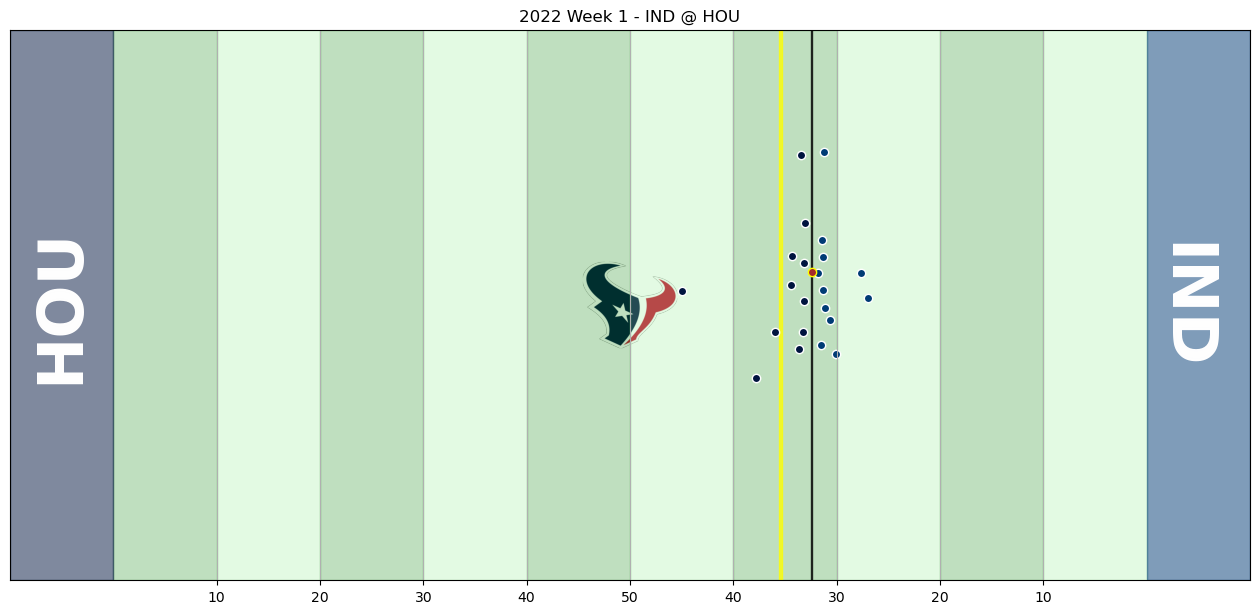

/var/folders/m8/xlwp526d3sxf6fyr2v802l_80000gn/T/ipykernel_44083/4208403530.py:124: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(last_frame[last_frame['club'] == team]['x'], last_frame[last_frame['club'] == team]['y']


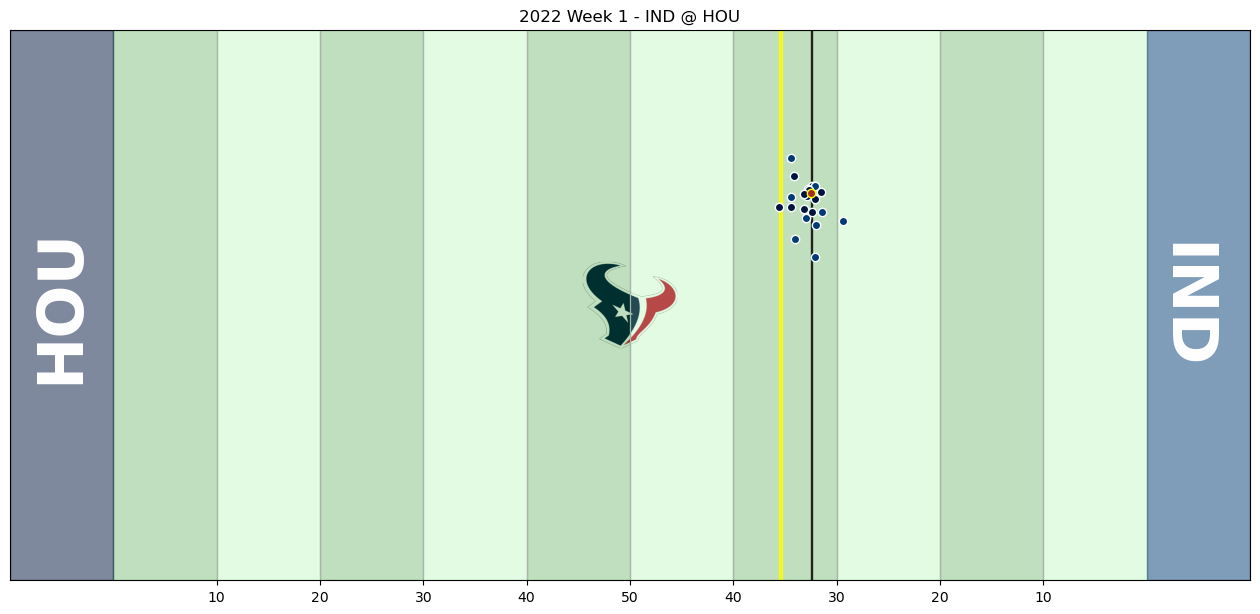

In [264]:
# Build Field and Play formation plot with Matplotlib

# Init figure and title
plt.figure(figsize=(16, 8))
plt.title(f"{game['season']} Week {game['week']} - {game['visitorTeamAbbr']} @ {game['homeTeamAbbr']}")

# Set x and y scales
plt.xlim(0, 120)  # Adjust the limits according to your data
plt.ylim(0, 53.3)  # Adjust the limits according to your data

# Create vertical bands of green and lightgreen for the field
for i in range(10, 101, 20):    
    plt.axvspan(i, i+10, color='green', alpha=0.25)
    plt.axvspan(i+10, i+20, color='lightgreen', alpha=0.25)

# Hide y-axis labels
plt.yticks(ticks=[], labels=[])

# Yard line labels
plt.xticks(ticks=[20,30,40,50,60,70,80,90,100],
           labels=['10','20','30','40','50','40','30','20','10'])

# Determine play orientation - which team is to the right
x_max = max(play_frame['x'])
max_team = play_frame.loc[(play_frame['x'] == x_max)].iloc[0]['club']

# Create end zone with team color and abbreviation
plt.annotate(max_team, xy=[113.5, 26.65], xytext=[113.5, 26.65], fontsize=45, 
            fontweight='bold',color='white', rotation=270,ha='center', va='center')
plt.axvspan(110, 120, color=colors[max_team], alpha=0.5)

# Determine play orientation - team to the left
x_min = min(play_frame['x'])
min_team = play_frame.loc[(play_frame['x'] == x_min)].iloc[0]['club']

# Create end zone with team color and abbreviation
plt.annotate(min_team, xy=[5,26.65], xytext=[5,26.65], fontsize=45, fontweight='bold',
             color='white', rotation=90,ha='center', va='center')
plt.axvspan(0, 10, color=colors[min_team], alpha=0.5)

# Plot home team logo at 50 yard line
plt.imshow(home_img, extent=[55,65,21.65,31.65])

# Determine x Position for First Down marker
if play_frame.iloc[2]['playDirection'] == 'right':
    first_down = play_frame.iloc[22]['x'] + play['yardsToGo']
else:
    first_down = play_frame.iloc[22]['x'] - play['yardsToGo']

# Plot first down and line of scrimmage markers
plt.axvspan(first_down-0.125, first_down+0.125, color='yellow', alpha=0.75)
plt.axvspan(play_frame.iloc[22]['x']-0.05, play_frame.iloc[22]['x']+0.05, color='black', alpha=0.75)

# Scatter plot for player and football positions
for team, color in colors.items():
    if team == 'football':
        edge = 'yellow'
    else:
        edge = 'white'
    plt.scatter(play_frame[play_frame['club'] == team]['x'], play_frame[play_frame['club'] == team]['y']
                ,c=color, label=team, alpha=1, edgecolor=edge)

# Show plot
plt.grid(True, axis='x')
plt.show()

# Init figure and title
plt.figure(figsize=(16, 8))
plt.title(f"{game['season']} Week {game['week']} - {game['visitorTeamAbbr']} @ {game['homeTeamAbbr']}")

# Set x and y scales
plt.xlim(0, 120)  # Adjust the limits according to your data
plt.ylim(0, 53.3)  # Adjust the limits according to your data

# Create vertical bands of green and lightgreen for the field
for i in range(10, 101, 20):    
    plt.axvspan(i, i+10, color='green', alpha=0.25)
    plt.axvspan(i+10, i+20, color='lightgreen', alpha=0.25)

# Hide y-axis labels
plt.yticks(ticks=[], labels=[])

# Yard line labels
plt.xticks(ticks=[20,30,40,50,60,70,80,90,100],
           labels=['10','20','30','40','50','40','30','20','10'])

# Determine play orientation - which team is to the right
x_max = max(play_frame['x'])
max_team = play_frame.loc[(play_frame['x'] == x_max)].iloc[0]['club']

# Create end zone with team color and abbreviation
plt.annotate(max_team, xy=[113.5, 26.65], xytext=[113.5, 26.65], fontsize=45, 
            fontweight='bold',color='white', rotation=270,ha='center', va='center')
plt.axvspan(110, 120, color=colors[max_team], alpha=0.5)

# Determine play orientation - team to the left
x_min = min(play_frame['x'])
min_team = play_frame.loc[(play_frame['x'] == x_min)].iloc[0]['club']

# Create end zone with team color and abbreviation
plt.annotate(min_team, xy=[5,26.65], xytext=[5,26.65], fontsize=45, fontweight='bold',
             color='white', rotation=90,ha='center', va='center')
plt.axvspan(0, 10, color=colors[min_team], alpha=0.5)

# Plot home team logo at 50 yard line
plt.imshow(home_img, extent=[55,65,21.65,31.65])

# Determine x Position for First Down marker
if play_frame.iloc[2]['playDirection'] == 'right':
    first_down = play_frame.iloc[22]['x'] + play['yardsToGo']
else:
    first_down = play_frame.iloc[22]['x'] - play['yardsToGo']

# Plot first down and line of scrimmage markers
plt.axvspan(first_down-0.125, first_down+0.125, color='yellow', alpha=0.75)
plt.axvspan(play_frame.iloc[22]['x']-0.05, play_frame.iloc[22]['x']+0.05, color='black', alpha=0.75)

# Scatter plot for player and football positions
for team, color in colors.items():
    if team == 'football':
        edge = 'yellow'
    else:
        edge = 'white'
    plt.scatter(last_frame[last_frame['club'] == team]['x'], last_frame[last_frame['club'] == team]['y']
                ,c=color, label=team, alpha=1, edgecolor=edge)

# Show plot
plt.grid(True, axis='x')
plt.show()

